# Synchronous Advantage Actor-Critic (A2C) Monte-Carlo

This is the A2C algorithm with a discrete action space (only works on environments with discrete actions) and Monte-Carlo parameter updates. Synchronous Advantage Actor-Critic (A2C) is an actor-critic method which runs multiple environments in parallel. A2C is a synchronous version of the asynchronous algorithm A3C. The updates will be performed in a Monte-Carlo way (parameter updates will only be performed at the end of the episode). This implementation is closer to a pure policy gradient approach than actor-critic, since bootstrapping is only used in the odd case that the environment doesn't enter a terminal state before the steps limit. 

The advantage function, $A^{\pi}$, following policy $\pi$ is defined by:
$$A^{\pi} = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$$
where $Q^{\pi}(s_t, a_t)$ is the action-value function following policy $\pi$ and $V^{\pi}(s_t)$ is the state-value function following policy $\pi$. The advantage function essentially measures the advantage gained (or lost) by taking the action $a_t$ in state $s_t$ over the average return of all immediate actions, and then following policy $\pi$ in the following states. We don't know the absolute value of the advantage, $A^{\pi}$, hence we need to find an advantage estimate, $\hat{A}$, as a substitute.

The advantage estimate used in A2C/A3C is given by:
$$\hat{A}_{t} = G_t - \hat{v}(S_t, w),$$ 
where $G_t$ is the discounted return for terminal episodes or the bootstrapped return for non-terminal episodes, and $\hat{v}(S_t, w)$ is the value estimate given state $S_t$ and parameters $w$. The bias-variance trade-off can be finetuned by altering the discount rate $\gamma$. Larger discount/decay rates lead to higher variance and lower bias and lower discount/decay rates lead to lower variance and higher bias. 


We will be using autograd to perform gradient descent on the policy and value functions. We only need to construct the objective functions (loss functions) and their derivatives will be calculated automatically. We will be using the Adam optimizer for both policy and value gradient updates. The loss functions will be combined into a single loss function. Autograd traces the paths of all the parameters for the gradient calculation, so combining the losses won't impact the gradient calculations. 

The policy objective function is given by:
$$L_{t}^{PF} = -\hat{E_t}[\log(\pi_\theta(a_t | s_t))\hat{A}_{t}].$$

The value objective function is given by:
$$L_{t}^{VF} = \hat{E_t}[\hat{A}_{t}^2].$$

The final objective function is given by:
$$L_{t} = \hat{E_t}[L_{t}^{PF} + c_{1}L_{t}^{VF} - c_{2}S_{\pi_{\theta}}(s_t)],$$
where $S_{\pi_{\theta}}(s_t)$ is the entropy of the policy function, and $c_{1}$, $c_{2}$ are the objective coefficients. Increasing $c_{1}$ will increase the update size on the value function (the same effect as increasing the learning rate) and increasing $c_{2}$ will make the policy function less deterministic. Decreasing the coefficients will have the opposite effect. 



For more information on A2C/A3C, see the original A3C paper [1] [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783), the notebook [2] [RL-Adventure-2 Actor-Critic Notebook](https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb).


In [1]:
import os
import numpy as np
import gymnasium as gym
from IPython.display import Video
import jax
import flax.linen as nn
from jax import value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from vec_env.subproc_vec_env import SubprocVecEnv
# Print numpy array floats with 2 decimal places
np.set_printoptions(precision=2, suppress=True)

In [2]:
# Type of environment, options include:
# CartPole-v1, MountainCar-v0
ENV_TYPE = "CartPole-v1"
# Choose number of parallel environments, 
# don't exceed the number of computer threads
num_envs = 10

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/a2c_discrete_monte-carlo/'

In [3]:
def make_env(env_id):
    """
    Returns a single environment object, 
    which will be used for parallel execution.
    """
    def _init():
        env = gym.make(env_id)
        return env
    return _init

In [4]:
# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])

num_actions = envs.action_space.n
obs_dims = envs.observation_space.shape
obs_upper_bounds = envs.observation_space.high
obs_lower_bounds = envs.observation_space.low

## Create The Policy 

In [5]:
class _policy_fn(nn.Module):
    """
    Policy function is an MLP used to choose the 
    best possible discrete action given the observations from the state.
    Each discrete action is given a probability from 0-1.
    The probability distribution can then be used 
    to stocastically choose the next action.  
    """
    num_actions: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(self.num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn(num_actions=num_actions)
# Display the model details
dummy_x = envs.reset()
dummy_x = jnp.array(dummy_x)
rng_key = jax.random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.



                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs          ┃ outputs         ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[10,4]   │ float32[10,2]   │                   │
├─────────┼────────────┼─────────────────┼─────────────────┼───────────────────┤
│ Dense_0 │ Dense      │ float32[10,4]   │ float32[10,256] │ bias:             │
│         │            │                 │                 │ float32[256]      │
│         │            │                 │                 │ kernel:           │
│         │            │                 │                 │ float32[4,256]    │
│         │            │                 │                 │                   │
│         │            │                 │                 │ 1,280 (5.1 KB)    │
├─────────┼────────────┼───

In [6]:
class _value_fn(nn.Module):
    """
    Value function is an MLP used to predict the expected return (value) 
    given the observations from the state.
    The value can then be used for bootstrapping, and/or 
    calculating the advantage from action chosen in the state. 
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                               _value_fn Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs          ┃ outputs         ┃ params             ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[10,4]   │ float32[10,1]   │                    │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_0 │ Dense     │ float32[10,4]   │ float32[10,256] │ bias: float32[256] │
│         │           │                 │                 │ kernel:            │
│         │           │                 │                 │ float32[4,256]     │
│         │           │                 │                 │                    │
│         │           │                 │                 │ 1,280 (5.1 KB)     │
├─────────┼───────────┼─────────────────┼─────────────────┼────────────────────┤
│ Dense_1 │ Dense     │ flo

In [7]:
def test_model(policy_variables, env, rng_key):
    """
    Runs a single episode following the policy function, 
    then returns the episodes rewards and steps.
    Args:
        policy_variables: Policy functions model parameters.
        env: Environment used to interact with.
        rng_key: Random number generator key.
    Returns:
        steps: Number of environment steps.
        episode_rewards: List of rewards from the episode.
    """

    terminated, truncated = False, False
    episode_rewards = []
    steps = 0

    state, _ = env.reset()
    while not (terminated or truncated):
        steps += 1
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(policy_variables, state)
        rng_key, subkey = jax.random.split(rng_key)
        action = jax.random.choice(subkey, jnp.arange(num_actions), p=action_dist)
        action = np.array(action)
        next_state, reward, terminated, truncated, info = env.step(action)

        episode_rewards.append(reward)

        state = next_state
    episode_rewards = np.array(episode_rewards)
    return steps, episode_rewards

    

In [8]:
def get_returns(
    gamma, next_value, rewards, done
):
    """
    Get discounted returns from rewards for each environment.
    Args:
        gamma: trajectory discount (scalar).
        next_value: value functions bootstrapped return for next state.
        rewards: agent rewards of taking actions in the environment.
        done: flag list for end of episode, 
            False indicates terminated, and True not terminated.
    Returns:
        Array of returns for each environment at each step.
    """
    batch_size = len(done)
    rewards = jnp.array(rewards)
    done = jnp.array(done)

    R = jnp.squeeze(next_value)
    returns = []

    for t in reversed(range(batch_size)):
        R = rewards[t] + (gamma * R * done[t])
        returns.append(R)

    returns = jnp.array(list(reversed(returns)))
    return returns

In [9]:
def loss_fn(value_variables, policy_variables, rng_key, gamma, max_steps, env_returns, env_steps):
    """
    Runs a single episode in a Monte-Carlo way, 
    then calculates the actor and critic losses, 
    which are then combined and returned.
    The gradients on this loss function are then used 
    to update the policy and actor functions.
    Args:
        value_variables: Value functions model parameters.
        policy_variables: Policy functions model parameters.
        rng_key: Random number generator key.
        gamma: Discount rate for discounting returns.
        max_steps: Limit on the number of steps in an episode.
        env_returns: List containing the returns from all environments each episode.
        env_steps: List containing the steps from all environments each episode.
    Returns:
        Combined loss of the value and actor functions.
    """
    terminated, truncated, term_or_trunc = jnp.repeat(False, num_envs), jnp.repeat(False, num_envs), jnp.repeat(False, num_envs)
    episode_log_probs = []
    episode_values = []
    episode_rewards = []
    done_flag = []
    steps = 0

    states = envs.reset()
    states = jnp.array(states)
    # Generate an episode following the policy
    while not term_or_trunc.all() and steps < max_steps:
        steps += 1
        # Select the action following the parametrized policy
        action_dists = policy_fn.apply(policy_variables, states)
        # Stocastically choose the next action based on the probability distribution
        actions = []
        for dist in action_dists:
            rng_key, subkey = jax.random.split(rng_key)
            action = jax.random.choice(subkey, jnp.arange(num_actions), p=dist)
            actions.append(action)
        actions = np.array(actions)
        
        next_states, rewards, terminated, truncated, info = envs.step(actions)
        # Check if env was terminated or truncated in this episode or one of the previous episodes 
        # We only want one episode per environment
        term_or_trunc = jnp.array([term or trunc or t_or_t for term, trunc, t_or_t in zip(terminated, truncated, term_or_trunc)])
        done_flag.append(jnp.invert(term_or_trunc))
        # If the episode previously ended, then set the reward to 0, 
        # we're ignoring rewards after the environment terminated
        rewards = jnp.array([reward if not t_or_t else 0 for reward, t_or_t in zip(rewards, term_or_trunc)])
        episode_rewards.append(rewards)
        # Log probabilities are needed for the actor loss
        log_probs = jnp.array([jnp.log(dist[action_index]) for dist, action_index in zip(action_dists, actions)])
        episode_log_probs.append(log_probs)
        # Entropy is used in the loss function to prevent the model from becoming too deterministic
        entropy = jnp.array([-jnp.sum(dist * jnp.log(dist)) for dist in action_dists])
        # Estimate the values given the states, then set all terminated states value to 0
        values = value_fn.apply(value_variables, states)
        values = jnp.squeeze(values)
        # We're ignoring values after the environment terminated
        values = [value if not t_or_t else 0.0 for value, t_or_t in zip(jnp.array(values), term_or_trunc)]
        values = jnp.array(values, dtype=jnp.float32)
        episode_values.append(values)

        states = next_states

    env_returns.append(list(np.array(episode_rewards).sum(axis=0)))
    env_steps.append(list(np.array(done_flag).sum(axis=0)))

    # Calculate the returns then 
    next_values = value_fn.apply(value_variables, next_states)
    returns = get_returns(gamma, next_values, episode_rewards, done_flag)
    episode_values = jnp.array(episode_values)
    advantages = returns - episode_values
    # Calculate actor and critic losses, then add entropy 
    episode_log_probs = jnp.array(episode_log_probs)
    actor_loss = -(advantages * episode_log_probs).mean(axis=0)
    critic_loss = (advantages**2).mean(axis=0)
    loss = (actor_loss + 0.5 * critic_loss - 0.001 * entropy).mean()

    return loss

## Learn The Optimal Action-Value Function

In [61]:
# Number of episodes to train on
episodes = 19
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 3
# Episode will terminate before max_steps
max_steps = 200
# Discount ratio
gamma = 0.99
# Step size
policy_alpha = 0.01
value_alpha = 0.01

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

# Create multiple envs for parallel execution
envs = SubprocVecEnv([make_env(ENV_TYPE) for _ in range(num_envs)])
if SAVE_VIDEOS:
    # Create a single environment for testing
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    test_returns = []
    test_steps = []
    env = gym.make(ENV_TYPE, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 1 == 0,
        video_length=0,
        name_prefix=f"{ENV_TYPE}",
        fps=30
        ) 
env_returns = []
env_steps = []
losses = []

for episode in range(episodes):
    print(f"Episode: {episode}")
    # Perform 6 tests and record them at even intervals
    if SAVE_VIDEOS and episode % (episodes // 5) == 0:
        test_step, test_rewards = test_model(policy_variables, env, rng_key)
        test_returns.append(np.sum(test_rewards))
        test_steps.append(test_step)
        test_episode = episode // (episodes // 5)
        print(f"\tTest Episode {test_episode} Return: {test_returns[test_episode] :.2f} Steps: {test_steps[test_episode] :.2f}")

    # Run a forward pass on the parallel envs (will last an entire episode) and 
    # calculate the gradients for value and policy functions 
    loss, (value_grads, policy_grads) = value_and_grad(loss_fn, argnums=(0, 1))(
        value_variables, 
        policy_variables, 
        rng_key, 
        gamma, 
        max_steps,
        env_returns,
        env_steps
    )
    # Update value function weights
    value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
    value_variables = optax.apply_updates(value_variables, value_updates)        
    # Update policy function weights
    policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
    policy_variables = optax.apply_updates(policy_variables, policy_updates)


    losses.append(loss)
    print(f'\tReturns: {env_returns[-1]}')
    print(f"\tAverage Return: {jnp.array(env_returns[-1]).mean() :.2f}")
    print(f"\tLoss: {loss :.2f}")

        

/home/ubuntu22/repos/reinforcement-learning-algorithms/venv-pre/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:415: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/ubuntu22/repos/reinforcement-learning-algorithms/venv-pre/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:282: UserWarning: WARN: Overwriting existing videos at /home/ubuntu22/repos/reinforcement-learning-algorithms/videos/a2c_discrete_monte-carlo folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode: 0
	Test Episode 0 Return: 20.00 Steps: 20.00
	Returns: [np.float64(11.0), np.float64(13.0), np.float64(20.0), np.float64(15.0), np.float64(35.0), np.float64(10.0), np.float64(26.0), np.float64(54.0), np.float64(13.0), np.float64(10.0)]
	Average Return: 20.70
	Loss: 58.08
Episode: 1
	Returns: [np.float64(14.0), np.float64(32.0), np.float64(33.0), np.float64(18.0), np.float64(81.0), np.float64(23.0), np.float64(38.0), np.float64(74.0), np.float64(21.0), np.float64(19.0)]
	Average Return: 35.30
	Loss: 143.06
Episode: 2
	Returns: [np.float64(50.0), np.float64(73.0), np.float64(61.0), np.float64(42.0), np.float64(31.0), np.float64(42.0), np.float64(30.0), np.float64(43.0), np.float64(36.0), np.float64(39.0)]
	Average Return: 44.70
	Loss: 177.27
Episode: 3
	Test Episode 1 Return: 78.00 Steps: 78.00
	Returns: [np.float64(29.0), np.float64(37.0), np.float64(56.0), np.float64(41.0), np.float64(39.0), np.float64(44.0), np.float64(53.0), np.float64(79.0), np.float64(33.0), np.float64(56.

## Plot The Results


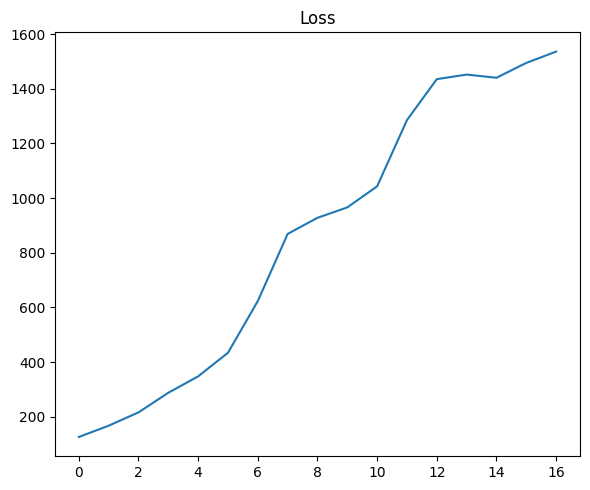

In [62]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 5))
axs.set_title("Loss")
loss_moving_average = (
    np.convolve(
        losses, np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs.plot(range(len(loss_moving_average)), loss_moving_average)
plt.tight_layout()
plt.show()

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

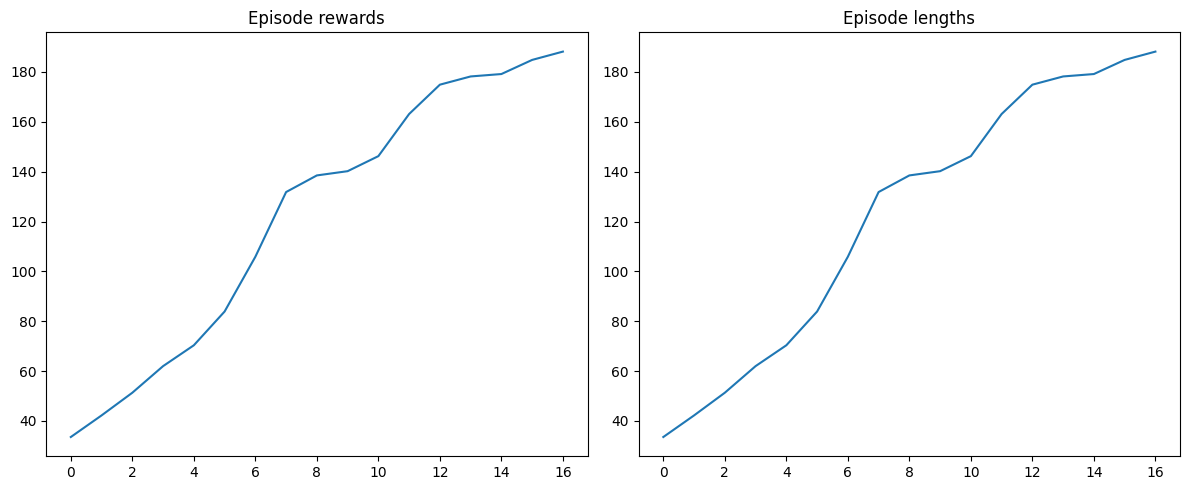

In [63]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env_returns).mean(axis=1), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env_steps).mean(axis=1), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

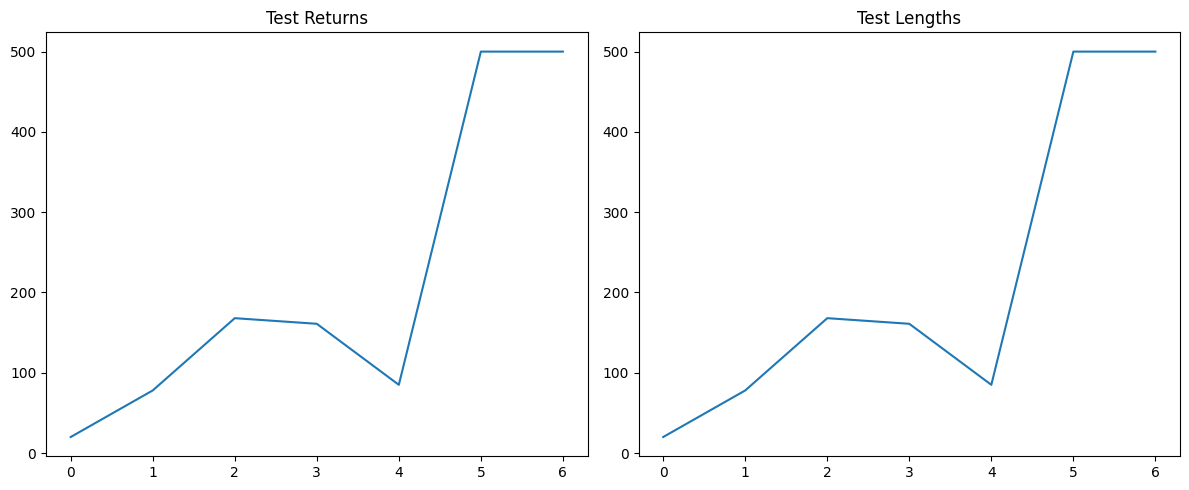

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Test Returns")
axs[0].plot(range(len(test_returns)), test_returns)
axs[1].set_title("Test Lengths")
axs[1].plot(range(len(test_steps)), test_steps)
plt.tight_layout()
plt.show()

## Testing Videos

### Test Episode 0

In [65]:
test_episode = 0
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 0 Return: 20.0


In [66]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 1

In [67]:
test_episode = 1
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 1 Return: 78.0


In [68]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 2

In [69]:
test_episode = 2
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 2 Return: 168.0


In [70]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 3

In [71]:
test_episode = 3
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 3 Return: 161.0


In [72]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 4

In [73]:
test_episode = 4
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 4 Return: 85.0


In [74]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")

### Test Episode 5

In [75]:
test_episode = 5
print(f"Test Episode {test_episode} Return: {test_returns[test_episode]}")

Test Episode 5 Return: 500.0


In [76]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-{test_episode}.mp4")